In [19]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math, copy
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import log_loss, confusion_matrix, accuracy_score, precision_score, recall_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler

In [20]:
# general settings
stdsc = StandardScaler()

target = 'state'
categorical = ['main_category', 'category', 'country']
quantitative = ['usd_goal_real', 'deadline', 'launched', 'duration', 'launched_time']

In [21]:
# functions
# around datetime objects
def datetime_to_hour(x):
    return x.hour

def datetime_to_int(pdSeries):
    values = (pdSeries - pdSeries.min()).dt.total_seconds()
    return values


# visualize categorical variables
def barplots(pdSeries):
    x = pdSeries.value_counts()
    plt.figure(figsize=(20, 5))
    sns.barplot(x.index, x.values)

# visualize categorical variables
def distplots(pdSeries):
    plt.figure(figsize=(20, 3))
    sns.distplot(pdSeries)

def cross_heatmap(data, exp_val, tar_val):
    crossmat = pd.crosstab(data[exp_val], data[tar_val], normalize='index')
    sns.heatmap(crossmat, annot=True, fmt='.3f', cmap='Blues')
    

# reshape pd.DataFrame into X, y
def ready_to_fit(data, target=target, quantitatives=quantitative, categoricals=categorical):
    y = pd.get_dummies(data[target])['successful'].to_numpy()
    
    X_qnt = data[quantitatives].to_numpy()
    X_cat = pd.get_dummies(data[categoricals]).to_numpy()
    X = np.concatenate([X_qnt, X_cat], axis=1)
    
    return X, y

# check performance of models
def show_scores(y_true, y_pred):
    ac = accuracy_score(y_true, y_pred)
    pr = precision_score(y_true, y_pred)
    re = recall_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)

    print(f'acurracy: {ac:.3f}, precision: {pr:.3f}, recall: {re:.3f}')
    print(f'MSE: {mse:.3f}, MAE: {mae:.3f}')


In [22]:
df_origin = pd.read_csv('ks-projects-201801.csv')

# objectives
1. See the effect of standardization.
2. See the effect of regularizatoion.

# outlines
1. Process data in the same way as practice.ipynb: saved as 'df_before'.
2. Standardize 'df_before': saved as 'df_std'
3. Check generalization performance by cross validation.
4. Try Regularization & compare generalization performance with the model in step3.

logistic normal
logistic regularized(L2, L1, ElasticNet)
SVM normal
SVM regularized(L2, L1, ElasticNet)
on each data, check generalization performance by cross validation.

### 1. Preprocess data in the same way as practice.ipynb

In [23]:
### 1. General processing
df = copy.copy(df_origin)
df = df.set_index('ID')

# exclude: ID, name, goal, pledged, usd pledged, use_pledged_real, backers
df = df.drop(['name', 'goal', 'pledged', 'usd pledged', 'usd_pledged_real', 'backers'], axis=1)

# Use data labeled only with 'successful' or 'failed'.
df = df[(df['state'] == 'successful') | (df['state'] == 'failed')]

### 2. Process categorical variables.
# currency to country, drop currency.
df.loc[(df['country']=='N,0"') & (df['currency']!="EUR"), 'country'] = df.loc[(df['country']=='N,0"') & (df['currency']!="EUR"), 'currency'].str[:2]
df.loc[(df['country']=='N,0"') & (df['currency']=="EUR"), 'country'] = "EU"
df = df.drop('currency', axis=1)

# 'category': replace values with too small counts with values in 'main_category'
x = df['category'].value_counts()
obj_to_replace = x.index[x.values < x.describe()['75%']]
df.loc[df['category'].isin(obj_to_replace), 'category'] = df.loc[df['category'].isin(obj_to_replace), 'main_category']


### 3. Process quantitative variables.
## 3-1. Convert 'usd_goal_real' into log scale.
df['usd_goal_real'] = df['usd_goal_real'].apply(math.log10)


## 3-2. Process datetime objects.
# make 'deadline' & 'launched' computable
df.loc[:, ['deadline', 'launched']] = df.loc[:, ['deadline', 'launched']].apply(pd.to_datetime)

# Add launched time zone to explanatories.
df['launched_time'] = df['launched'].apply(datetime_to_hour)

# convert datetime objects to integers
df['deadline'] = datetime_to_int(df['deadline'])
df['launched'] = datetime_to_int(df['launched'])

# remove data that have too small launched values
# df: 378559 rows × 8 columns
df = df.loc[df['launched']!=0, :]
# df: 378552 rows × 8 columns

# generate 'duration' column
df['duration'] = df['deadline'] - df['launched']

df_before = copy.copy(df)
df_before.describe(include='all')

,category,main_category,deadline,launched,state,country,usd_goal_real,launched_time,duration
count,331674,331674,3.316740e+05,3.316740e+05,331674,331674,331674.000000,331674.000000,3.316740e+05
unique,42,15,NaN,NaN,2,23,NaN,NaN,NaN
top,Music,Film & Video,NaN,NaN,failed,US,NaN,NaN,NaN
freq,23651,56527,NaN,NaN,197718,261510,NaN,NaN,NaN
mean,NaN,NaN,1.712436e+08,1.693197e+08,NaN,NaN,3.726612,13.087369,1.923809e+06
std,NaN,NaN,6.058307e+07,6.076608e+07,NaN,NaN,0.726712,7.715455,1.099302e+06
min,NaN,NaN,0.000000e+00,9.750500e+04,NaN,NaN,-2.000000,0.000000,-9.605950e+05
25%,NaN,NaN,1.260576e+08,1.242509e+08,NaN,NaN,3.301030,5.000000,1.552251e+06
50%,NaN,NaN,1.767744e+08,1.748924e+08,NaN,NaN,3.698970,16.000000,1.601312e+06
75%,NaN,NaN,2.188512e+08,2.170096e+08,NaN,NaN,4.176091,20.000000,2.123911e+06


### 2. Standardize

In [24]:
df_std = copy.copy(df)

df_qnt = df_std[quantitative]
df_qnt_scaled = pd.DataFrame(stdsc.fit_transform(df_qnt.values), columns=quantitative, index=df_std.index)
df_std[quantitative] = df_qnt_scaled[quantitative]

display(df_std.head())

,category,main_category,deadline,launched,state,country,usd_goal_real,launched_time,duration
ID,,,,,,,,,
1000002330,Publishing,Publishing,0.524841,0.487569,failed,GB,-0.744176,-0.140934,1.972902
1000003930,Narrative Film,Film & Video,1.600153,1.557778,failed,US,1.032748,-1.177815,2.075977
1000004038,Narrative Film,Film & Video,-0.837125,-0.851092,failed,US,1.275060,-1.696256,0.911406
1000007540,Music,Music,-1.287787,-1.278888,failed,US,-0.038038,-1.307426,-0.277533
1000014025,Restaurants,Food,0.774416,0.770602,successful,US,1.338025,-0.011324,0.081918


In [25]:
clf = SGDClassifier(loss='log',
                    # penalty='l2',
                    # l1_ratio=0.15, # for ElasticNet
                    fit_intercept=True,
                    random_state=1234,
                    max_iter=1e5,
                    tol=1e-3)

# clf_before = clf.fit(X, y) # too heavy calculation

X, y = ready_to_fit(df_std)
clf_std = clf.fit(X, y)

y_est = clf_std.predict(X)
show_scores(y, y_est)


acurracy: 0.667, precision: 0.616, recall: 0.464
MSE: 0.333, MAE: 55.322


c:\Users\masa_\anaconda3\envs\suai\lib\site-packages\sklearn\linear_model\base.py:283: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indices = (scores > 0).astype(np.int)


### 3. Validation
#### Holdout

In [26]:
# model instance
clf = SGDClassifier(loss='log',
                    # penalty='l2',
                    # l1_ratio=0.15, # for ElasticNet
                    fit_intercept=True,
                    random_state=1234,
                    max_iter=1e5,
                    tol=1e-3)


# data set
X, y = ready_to_fit(df_std)

# Holdout
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)
# In practice, you have to split data before standardization, fit StandardScaler only to train data, and use the params when fitting test data.

clf.fit(X_train, y_train)

y_est_train = clf.predict(X_train)
y_est_test = clf.predict(X_test)

print('scores on train dataset')
show_scores(y_train, y_est_train)

print('')

print('scores on train dataset')
show_scores(y_test, y_est_test)


scores on train dataset
acurracy: 0.665, precision: 0.610, recall: 0.474
MSE: 0.335, MAE: 54.299

scores on train dataset
acurracy: 0.670, precision: 0.614, recall: 0.483
MSE: 0.330, MAE: 53.213


c:\Users\masa_\anaconda3\envs\suai\lib\site-packages\sklearn\linear_model\base.py:283: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indices = (scores > 0).astype(np.int)
c:\Users\masa_\anaconda3\envs\suai\lib\site-packages\sklearn\linear_model\base.py:283: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to revie

#### Result of Holdout
**Scores on train dataset**  
acurracy: 0.665, precision: 0.610, recall: 0.474  
MSE: 0.335, MAE: 54.299  
  
**Scores on TEST dataset**  
acurracy: 0.670, precision: 0.614, recall: 0.483  
MSE: 0.330, MAE: 53.213  
  
そもそも精度は高くないが、過学習は起こってない模様


#### Cross validation

In [27]:
# model instance
clf = SGDClassifier(loss='log',
                    # penalty='l2',
                    # l1_ratio=0.15, # for ElasticNet
                    fit_intercept=True,
                    random_state=1234,
                    max_iter=1e5,
                    tol=1e-3)

kf = KFold(n_splits=5, shuffle=True, random_state=1234)
X, y = ready_to_fit(df_std)

maes, mses = list(), list()
for train_idx, test_idx in kf.split(X):
    # print('Train', train_idx, 'test', test_idx) # practice
    X_train, X_test, y_train, y_test = X[train_idx], X[test_idx], y[train_idx], y[test_idx]
    clf.fit(X_train, y_train)
    y_est_test = clf.predict(X_test)
    maes.append(mean_absolute_error(y_test, y_est_test))
    mses.append(mean_squared_error(y_test, y_est_test))


c:\Users\masa_\anaconda3\envs\suai\lib\site-packages\sklearn\model_selection\_split.py:437: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fold_sizes = np.full(n_splits, n_samples // n_splits, dtype=np.int)
c:\Users\masa_\anaconda3\envs\suai\lib\site-packages\sklearn\model_selection\_split.py:113: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Depreca

In [28]:
print('MAE', maes)
print('MSE', mses)

MAE [54.34034823245647, 57.24703399412075, 58.457556342805454, 48.03415994573, 56.35060451653752]
MSE [0.3316047335494083, 0.33970000753749907, 0.33258460842692394, 0.33569005803874274, 0.3307655199445232]


### 4. Regularizaiton

In [29]:
clf = SGDClassifier(loss='log',
                    penalty='l1',
                    # l1_ratio=0.15, # for ElasticNet
                    fit_intercept=True,
                    random_state=1234,
                    max_iter=1e5,
                    tol=1e-3)

kf = KFold(n_splits=5, shuffle=True, random_state=1234)
X, y = ready_to_fit(df_std)

maes_l1, mses_l1 = list(), list()
for train_idx, test_idx in kf.split(X):
    # print('Train', train_idx, 'test', test_idx) # practice
    X_train, X_test, y_train, y_test = X[train_idx], X[test_idx], y[train_idx], y[test_idx]
    clf.fit(X_train, y_train)
    y_est_test = clf.predict(X_test)
    maes_l1.append(mean_absolute_error(y_test, y_est_test))
    mses_l1.append(mean_squared_error(y_test, y_est_test))


c:\Users\masa_\anaconda3\envs\suai\lib\site-packages\sklearn\model_selection\_split.py:437: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fold_sizes = np.full(n_splits, n_samples // n_splits, dtype=np.int)
c:\Users\masa_\anaconda3\envs\suai\lib\site-packages\sklearn\model_selection\_split.py:113: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Depreca

In [30]:
print('MAE_L1', maes_l1)
print('MAE', maes)

print('')

print('MSE', mses)
print('MSE_L1', mses_l1)

MAE_L1 [52.39155800105525, 57.41876837265395, 50.60874349890706, 60.69500263812467, 53.8980764012422]
MAE [54.34034823245647, 57.24703399412075, 58.457556342805454, 48.03415994573, 56.35060451653752]

MSE [0.3316047335494083, 0.33970000753749907, 0.33258460842692394, 0.33569005803874274, 0.3307655199445232]
MSE_L1 [0.33180070852491145, 0.3391271576091053, 0.3333232833345896, 0.3338659832667521, 0.33269514879247447]


別に過学習してないから正則化してもあんま意味なかった。

### 5. Support Vector Machine

,category,main_category,deadline,launched,state,country,usd_goal_real,launched_time,duration
ID,,,,,,,,,
1000002330,Publishing,Publishing,0.524841,0.487569,failed,GB,-0.744176,-0.140934,1.972902
1000003930,Narrative Film,Film & Video,1.600153,1.557778,failed,US,1.032748,-1.177815,2.075977
1000004038,Narrative Film,Film & Video,-0.837125,-0.851092,failed,US,1.275060,-1.696256,0.911406
1000007540,Music,Music,-1.287787,-1.278888,failed,US,-0.038038,-1.307426,-0.277533
1000014025,Restaurants,Food,0.774416,0.770602,successful,US,1.338025,-0.011324,0.081918


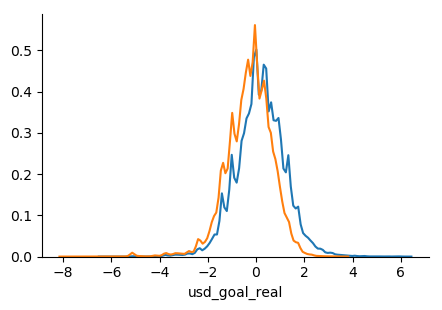

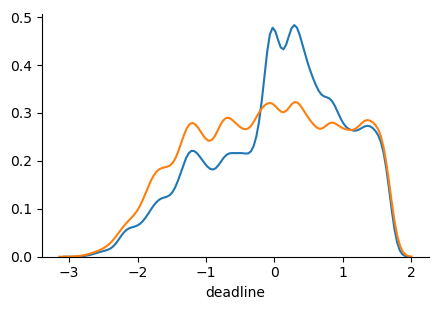

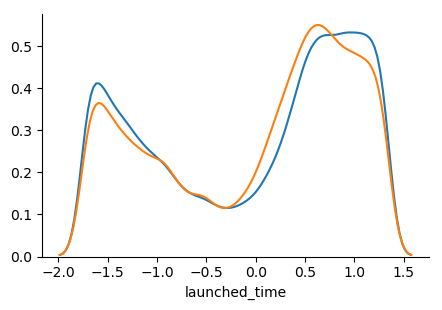

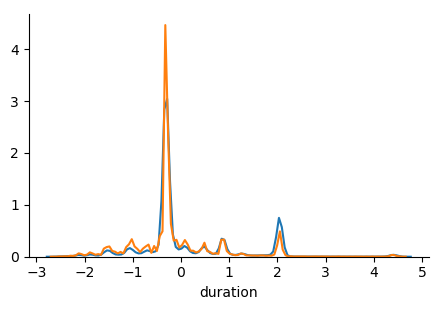

(None, None, None, None)

In [31]:
display(df_std.head())

def plotdist_sns(x):
    grid = sns.FacetGrid(data=df_std, hue='state', height=3.2, aspect=1.414)
    grid.map(sns.distplot, x, hist=False)
    plt.show()

plotdist_sns('usd_goal_real'), plotdist_sns('deadline'), plotdist_sns('launched_time'), plotdist_sns('duration')
# plotdist_sns('launched') was almost the same as that of 'deadline'
# df[['deadline', 'launched']].corr() # 0.99984

In [32]:
# sns.scatterplot(data=df_std, x='deadline', y='usd_goal_real', hue='state')

In [33]:
# sns.scatterplot(data=df_std, x='duration', y='usd_goal_real', hue='state')


In [34]:
# sns.scatterplot(data=df_std, x='launched_time', y='usd_goal_real', hue='state')

In [35]:
display(df_std.head())

,category,main_category,deadline,launched,state,country,usd_goal_real,launched_time,duration
ID,,,,,,,,,
1000002330,Publishing,Publishing,0.524841,0.487569,failed,GB,-0.744176,-0.140934,1.972902
1000003930,Narrative Film,Film & Video,1.600153,1.557778,failed,US,1.032748,-1.177815,2.075977
1000004038,Narrative Film,Film & Video,-0.837125,-0.851092,failed,US,1.275060,-1.696256,0.911406
1000007540,Music,Music,-1.287787,-1.278888,failed,US,-0.038038,-1.307426,-0.277533
1000014025,Restaurants,Food,0.774416,0.770602,successful,US,1.338025,-0.011324,0.081918


In [36]:
C = 1
kernel = 'rbf'
gamma = .1

clf = SVC(C=C, kernel=kernel, gamma=gamma)

X, y = ready_to_fit(df_std)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234, shuffle=True)
# X_train.shape, X_test.shape, y_train.shape, y_test.shape
# clf.fit(X_train, y_train)

# clf.fit(X_train[:, np.arange(5)], y)
# 説明変数減らしても計算終わんない

# clf.fit(X_train[np.arange(100),:], y_trai cn[np.arange(100)])
# clf.fit(X_train[np.arange(1000),:], y_trai cn[np.arange(1000)])
# clf.fit(X_train[np.arange(10000),:], y_trai cn[np.arange(10000)])
# データ数10000くらいまでなら耐える
# clf.fit(X_train[np.arange(100000),:], y_trai cn[np.arange(100000)])
# 学習終わらない、ダミー変数を0, 1じゃなくて-1, 1にすればいける？

In [69]:
X_qnt = X[:, np.arange(5)]
X_cat = X[:, np.arange(5, 85)]
# X_qnt, X_cat
X_cat_svm = np.where(X_cat == 0, -1, 1)
y_svm = np.where(y==0, -1, 1)
X_qnt, X_cat, X_cat_svm
# y, y_svm

X_svm = np.concatenate([X_qnt, X_cat_svm], axis=1)
X_svm.shape, y_svm

# clf.fit(X_svm, y_svm)
全然計算終わらん